In [3]:
from spectra_tanimoto_splits import lipo_dataset
#from spectra_tanimoto_splits import sider_smiles
%pip install spectrae


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import deepchem as dc
import chemprop
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw, AllChem, rdFingerprintGenerator
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from tqdm import tqdm
import os
import shutil
import pickle
from spectrae import Spectra, SpectraDataset

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with p

In [11]:
class molnet_dataset(SpectraDataset):

  def parse(self, dataset):
    return dataset

  def __len__(self):
    return len(self.samples)

  def sample_to_index(self,sample):
    if not hasattr(self, 'index_to_sequence'):
      print('Generating index to sequence')
      self.index_to_sequence = {}
      for i in tqdm(range(len(self.samples))):
        x = self.__getitem__(i)
        self.index_to_sequence[x] = i
    return self.index_to_sequence[sample]

  def __getitem__(self, idx):
    return self.samples[idx]

In [12]:
class molnet_hamming_spectra(Spectra):
  def spectra_properties(self, sample_one, sample_two):
      return np.sum(sample_one != sample_two)/1024

  def cross_split_overlap(self, train, test):
    average_similarity = []
    for i in train:
      for j in test:
        average_similarity.append(self.spectra_properties(i,j))
    return np.mean(average_similarity)

In [14]:
spectra_parameters = {'number_repeats': 3,
                      'random_seed': [42,44,46],
                      'spectral_parameters':["{:.2f}".format(i) for i in np.arange(0,1.05,0.05)],
                      'force_reconstruct': False,
                      }

In [70]:
tasks,sider_datasets,transformers = dc.molnet.load_sider(splitter = None)
sider_smiles = sider_datasets[0].ids

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/nw/dmqw9gpx73qbkd9bkclq0hsm0000gn/T/sider-featurized/CircularFingerprint_size_1024/None/BalancingTransformer/transformers.pkl'

In [69]:
mfp_sider = []
for i in range(len(sider_smiles)):
  mol = Chem.MolFromSmiles(sider_smiles[i])
  fp = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024).GetFingerprint(mol)
  mfp_sider.append(fp)
mfp_sider = np.array(mfp_sider)

mfp_sider

NameError: name 'sider_smiles' is not defined

In [19]:
sider_dataset = molnet_dataset(mfp_sider, 'sider')
sider_spectra = molnet_hamming_spectra(sider_dataset, binary = False)
sider_spectra.pre_calculate_spectra_properties('sider',force_recalculate = True)

100%|██████████| 1427/1427 [00:03<00:00, 428.87it/s]


In [20]:
sider_spectra.generate_spectra_splits(**spectra_parameters)

100%|██████████| 1017451/1017451 [00:01<00:00, 952193.26it/s]


Stats for SPECTRA property graph (SPG)
Number of nodes: 1427
Number of edges: 1017447
Number of connected components: 1


Generating SPECTRA split for spectral parameter 0.0 and dataset sider
Number of samples in independent set: 1427
Train size: 1141	Test size: 286
Cross split overlap: 0.07413093520743061



Generating SPECTRA split for spectral parameter 0.0 and dataset sider
Number of samples in independent set: 1427
Train size: 1141	Test size: 286
Cross split overlap: 0.07386192459764163



Generating SPECTRA split for spectral parameter 0.0 and dataset sider
Number of samples in independent set: 1427
Train size: 1141	Test size: 286
Cross split overlap: 0.07228087228626436



Generating SPECTRA split for spectral parameter 0.05 and dataset sider
Number of samples in independent set: 1304
Train size: 1043	Test size: 261
Cross split overlap: 0.06493489698128924



Generating SPECTRA split for spectral parameter 0.05 and dataset sider
Number of samples in independent set: 1309
Train s

[]

In [25]:
stats_sider = sider_spectra.return_all_split_stats()
stats_sider_df = pd.DataFrame(stats_sider).sort_values(by = 'SPECTRA_parameter', ascending = True)

print('SPECTRA Splits on Hamming Distance of SIDER')
print('----------------------')
for index, row in stats_sider_df.iterrows():
  print(f'SPECTRA parameter: {row["SPECTRA_parameter"]}')
  print(f'Train size: {row["train_size"]} | Test size: {row["test_size"]}')
  print(f'Cross split overlap: {row["cross_split_overlap"]} \n')

SPECTRA Splits on Hamming Distance of SIDER
----------------------
SPECTRA parameter: 0.0
Train size: 1141 | Test size: 286
Cross split overlap: 0.07413093520743061 

SPECTRA parameter: 0.0
Train size: 1141 | Test size: 286
Cross split overlap: 0.07386192459764163 

SPECTRA parameter: 0.0
Train size: 1141 | Test size: 286
Cross split overlap: 0.07228087228626436 

SPECTRA parameter: 0.05
Train size: 978 | Test size: 245
Cross split overlap: 0.06473449449756896 

SPECTRA parameter: 0.05
Train size: 1047 | Test size: 262
Cross split overlap: 0.06502558285167727 

SPECTRA parameter: 0.05
Train size: 1043 | Test size: 261
Cross split overlap: 0.06493489698128924 

SPECTRA parameter: 0.1
Train size: 992 | Test size: 249
Cross split overlap: 0.06207429975066597 

SPECTRA parameter: 0.1
Train size: 978 | Test size: 245
Cross split overlap: 0.0613567155677455 

SPECTRA parameter: 0.1
Train size: 988 | Test size: 247
Cross split overlap: 0.06112986883851153 

SPECTRA parameter: 0.15
Train size:

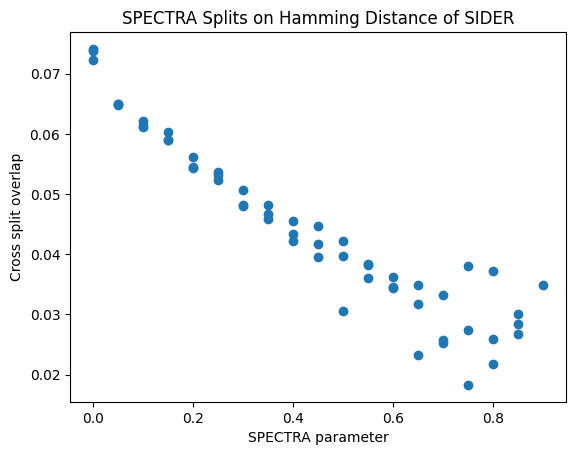

In [28]:
import matplotlib.pyplot as plt
plt.scatter(stats_sider['SPECTRA_parameter'], stats_sider['cross_split_overlap'])
plt.xlabel('SPECTRA parameter')
plt.ylabel('Cross split overlap')
plt.title('SPECTRA Splits on Hamming Distance of SIDER')
plt.show()

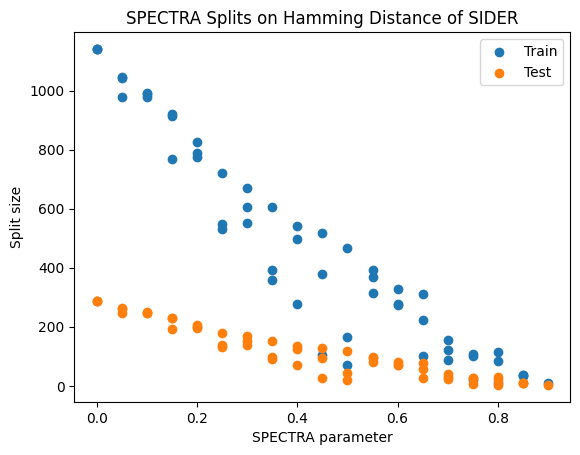

In [29]:
plt.scatter(stats_sider['SPECTRA_parameter'], stats_sider['train_size'])
plt.scatter(stats_sider['SPECTRA_parameter'], stats_sider['test_size'])
plt.xlabel('SPECTRA parameter')
plt.ylabel('Split size')
plt.legend(['Train','Test'])
plt.title('SPECTRA Splits on Hamming Distance of SIDER')
plt.show()

In [8]:
tasks,bbbp_datasets,transformers = dc.molnet.load_bbbp(splitter = None)
bbbp_smiles = bbbp_datasets[0].ids

In [9]:
mfp_bbbp = []
for i in range(len(bbbp_smiles)):
  mol = Chem.MolFromSmiles(bbbp_smiles[i])
  fp = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024).GetFingerprint(mol)
  mfp_bbbp.append(fp)
mfp_bbbp = np.array(mfp_bbbp)
print(len(mfp_bbbp))

[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not removing hydrogen atom without neighbors
[18:17:32] WARNING: not r

2039


In [10]:
bbbp_dataset = molnet_dataset(mfp_bbbp, 'bbbp')
bbbp_spectra = molnet_hamming_spectra(bbbp_dataset, binary = False)
bbbp_spectra.pre_calculate_spectra_properties('bbbp',force_recalculate = True)

100%|██████████| 2039/2039 [00:06<00:00, 305.48it/s]


In [11]:
bbbp_spectra.generate_spectra_splits(**spectra_parameters)

100%|██████████| 2077741/2077741 [00:01<00:00, 1085948.69it/s]


Stats for SPECTRA property graph (SPG)
Number of nodes: 2039
Number of edges: 2077646
Number of connected components: 1


Generating SPECTRA split for spectral parameter 0.0 and dataset bbbp
Number of samples in independent set: 2039
Train size: 1631	Test size: 408
Cross split overlap: 0.06569707667804246



Generating SPECTRA split for spectral parameter 0.0 and dataset bbbp
Number of samples in independent set: 2039
Train size: 1631	Test size: 408
Cross split overlap: 0.06604432570708005



Generating SPECTRA split for spectral parameter 0.0 and dataset bbbp
Number of samples in independent set: 2039
Train size: 1631	Test size: 408
Cross split overlap: 0.06626837002571952



Generating SPECTRA split for spectral parameter 0.05 and dataset bbbp
Number of samples in independent set: 1621
Train size: 1296	Test size: 325
Cross split overlap: 0.059070505864939456



Generating SPECTRA split for spectral parameter 0.05 and dataset bbbp
Number of samples in independent set: 1767
Train size:

[]

In [14]:
bbbp_stats = bbbp_spectra.return_all_split_stats()
bbbp_stats_df = pd.DataFrame(bbbp_stats).sort_values(by = 'SPECTRA_parameter', ascending = True)

print('SPECTRA Splits on Hamming Distance of BBBP')
print('----------------------')
for index, row in bbbp_stats_df.iterrows():
  print(f'SPECTRA parameter: {row["SPECTRA_parameter"]}')
  print(f'Train size: {row["train_size"]} | Test size: {row["test_size"]}')
  print(f'Cross split overlap: {row["cross_split_overlap"]} \n')

SPECTRA Splits on Hamming Distance of BBBP
----------------------
SPECTRA parameter: 0.0
Train size: 1631 | Test size: 408
Cross split overlap: 0.06569707667804246 

SPECTRA parameter: 0.0
Train size: 1631 | Test size: 408
Cross split overlap: 0.06604432570708005 

SPECTRA parameter: 0.0
Train size: 1631 | Test size: 408
Cross split overlap: 0.06626837002571952 

SPECTRA parameter: 0.05
Train size: 1413 | Test size: 354
Cross split overlap: 0.06063441190071711 

SPECTRA parameter: 0.05
Train size: 1399 | Test size: 350
Cross split overlap: 0.05923366020371694 

SPECTRA parameter: 0.05
Train size: 1296 | Test size: 325
Cross split overlap: 0.059070505864939456 

SPECTRA parameter: 0.1
Train size: 1181 | Test size: 296
Cross split overlap: 0.05604057050988197 

SPECTRA parameter: 0.1
Train size: 1220 | Test size: 305
Cross split overlap: 0.055918223322863475 

SPECTRA parameter: 0.1
Train size: 1140 | Test size: 285
Cross split overlap: 0.05593649909106648 

SPECTRA parameter: 0.15
Train

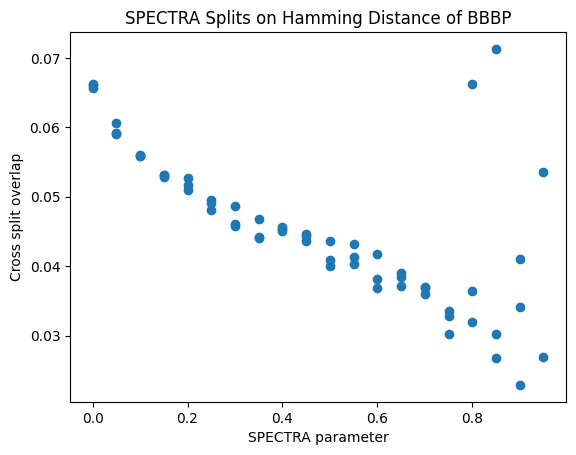

In [16]:
import matplotlib.pyplot as plt
plt.scatter(bbbp_stats['SPECTRA_parameter'], bbbp_stats['cross_split_overlap'])
plt.xlabel('SPECTRA parameter')
plt.ylabel('Cross split overlap')
plt.title('SPECTRA Splits on Hamming Distance of BBBP')
plt.show()

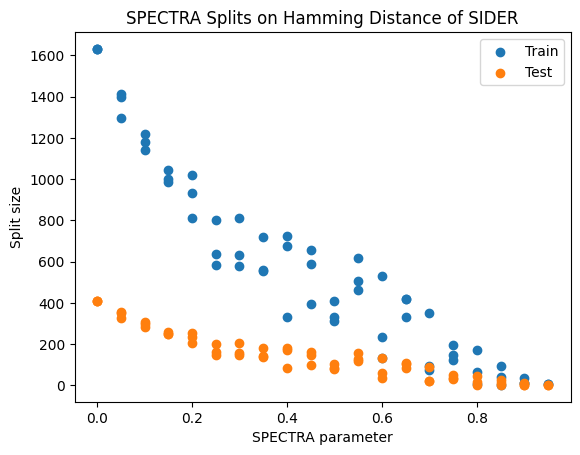

In [17]:
plt.scatter(bbbp_stats['SPECTRA_parameter'], bbbp_stats['train_size'])
plt.scatter(bbbp_stats['SPECTRA_parameter'], bbbp_stats['test_size'])
plt.xlabel('SPECTRA parameter')
plt.ylabel('Split size')
plt.legend(['Train','Test'])
plt.title('SPECTRA Splits on Hamming Distance of SIDER')
plt.show()

In [5]:
tasks, clintox_datasets,transformers = dc.molnet.load_clintox(splitter = None)
clintox_smiles = clintox_datasets[0].ids

In [9]:
mfp_clintox = []

for i in range(len(clintox_smiles)):
    mol = Chem.MolFromSmiles(clintox_smiles[i])
    fp = rdFingerprintGenerator.GetMorganGenerator(radius = 2, fpSize = 1024).GetFingerprint(mol)
    mfp_clintox.append(fp)

mfp_clintox = np.array(mfp_clintox)

In [20]:
clintox_dataset = molnet_dataset(mfp_clintox, 'clintox')
clintox_spectra = molnet_hamming_spectra(clintox_dataset, binary = False)
clintox_spectra.pre_calculate_spectra_properties('clintox',force_recalculate = False)

100%|██████████| 1480/1480 [00:03<00:00, 458.12it/s]


In [16]:
clintox_spectra.generate_spectra_splits(**spectra_parameters)

100%|██████████| 1094460/1094460 [00:00<00:00, 1133016.79it/s]


Stats for SPECTRA property graph (SPG)
Number of nodes: 1480
Number of edges: 1094407
Number of connected components: 1


Generating SPECTRA split for spectral parameter 0.0 and dataset clintox
Number of samples in independent set: 1480
Train size: 1184	Test size: 296
Cross split overlap: 0.0693877661114979



Generating SPECTRA split for spectral parameter 0.0 and dataset clintox
Number of samples in independent set: 1480
Train size: 1184	Test size: 296
Cross split overlap: 0.06828787380800881



Generating SPECTRA split for spectral parameter 0.0 and dataset clintox
Number of samples in independent set: 1480
Train size: 1184	Test size: 296
Cross split overlap: 0.07000931376867524



Generating SPECTRA split for spectral parameter 0.05 and dataset clintox
Number of samples in independent set: 1319
Train size: 1055	Test size: 264
Cross split overlap: 0.06304797175696539



Generating SPECTRA split for spectral parameter 0.05 and dataset clintox
Number of samples in independent set: 135

[]

In [17]:
clintox_stats = clintox_spectra.return_all_split_stats()
clintox_stats_df = pd.DataFrame(clintox_stats).sort_values(by = 'SPECTRA_parameter', ascending = True)

print('SPECTRA Splits on Hamming Distance of ClinTox')
print('----------------------')
for index, row in clintox_stats_df.iterrows():
  print(f'SPECTRA parameter: {row["SPECTRA_parameter"]}')
  print(f'Train size: {row["train_size"]} | Test size: {row["test_size"]}')
  print(f'Cross split overlap: {row["cross_split_overlap"]} \n')

SPECTRA Splits on Hamming Distance of ClinTox
----------------------
SPECTRA parameter: 0.0
Train size: 1184 | Test size: 296
Cross split overlap: 0.06828787380800881 

SPECTRA parameter: 0.0
Train size: 1184 | Test size: 296
Cross split overlap: 0.07000931376867524 

SPECTRA parameter: 0.0
Train size: 1184 | Test size: 296
Cross split overlap: 0.0693877661114979 

SPECTRA parameter: 0.05
Train size: 1080 | Test size: 270
Cross split overlap: 0.0634418268818587 

SPECTRA parameter: 0.05
Train size: 1055 | Test size: 264
Cross split overlap: 0.06304797175696539 

SPECTRA parameter: 0.05
Train size: 1076 | Test size: 269
Cross split overlap: 0.06324744259144256 

SPECTRA parameter: 0.1
Train size: 980 | Test size: 245
Cross split overlap: 0.05958980307684298 

SPECTRA parameter: 0.1
Train size: 888 | Test size: 222
Cross split overlap: 0.05873223704067243 

SPECTRA parameter: 0.1
Train size: 974 | Test size: 244
Cross split overlap: 0.05985108202612179 

SPECTRA parameter: 0.15
Train siz

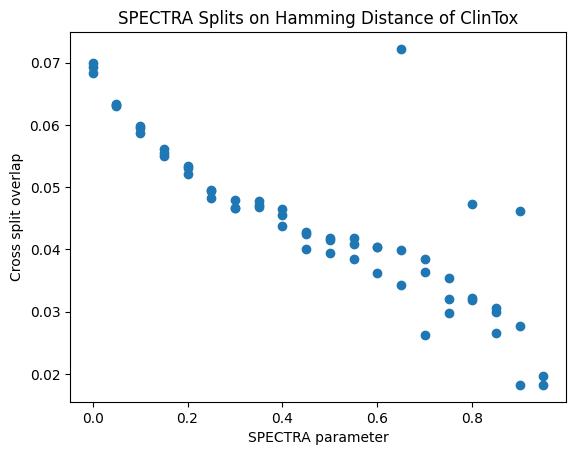

In [18]:
import matplotlib.pyplot as plt
plt.scatter(clintox_stats['SPECTRA_parameter'], clintox_stats['cross_split_overlap'])
plt.xlabel('SPECTRA parameter')
plt.ylabel('Cross split overlap')
plt.title('SPECTRA Splits on Hamming Distance of ClinTox')
plt.show()

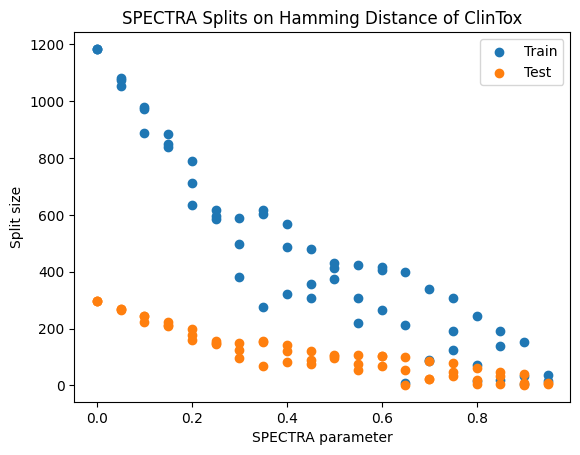

In [19]:
plt.scatter(clintox_stats['SPECTRA_parameter'], clintox_stats['train_size'])
plt.scatter(clintox_stats['SPECTRA_parameter'], clintox_stats['test_size'])
plt.xlabel('SPECTRA parameter')
plt.ylabel('Split size')
plt.legend(['Train','Test'])
plt.title('SPECTRA Splits on Hamming Distance of ClinTox')
plt.show()

In [23]:
tasks, delaney_datasets,transformers = dc.molnet.load_delaney(splitter = None)
delaney_smiles = delaney_datasets[0].ids

In [25]:
mfp_delaney = []

for i in range(len(delaney_smiles)):
    mol = Chem.MolFromSmiles(delaney_smiles[i])
    fp = rdFingerprintGenerator.GetMorganGenerator(radius = 2, fpSize = 1024).GetFingerprint(mol)
    mfp_delaney.append(fp)

mfp_delaney = np.array(mfp_delaney)

In [26]:
delaney_dataset = molnet_dataset(mfp_delaney, 'delaney')
delaney_spectra = molnet_hamming_spectra(delaney_dataset, binary = False)
delaney_spectra.pre_calculate_spectra_properties('delaney')

100%|██████████| 1128/1128 [00:01<00:00, 617.55it/s] 


In [27]:
delaney_spectra.generate_spectra_splits(**spectra_parameters)

100%|██████████| 635628/635628 [00:00<00:00, 1107906.34it/s]


Stats for SPECTRA property graph (SPG)
Number of nodes: 1128
Number of edges: 635508
Number of connected components: 1


Generating SPECTRA split for spectral parameter 0.0 and dataset delaney
Number of samples in independent set: 1128
Train size: 902	Test size: 226
Cross split overlap: 0.03564631333332516



Generating SPECTRA split for spectral parameter 0.0 and dataset delaney
Number of samples in independent set: 1128
Train size: 902	Test size: 226
Cross split overlap: 0.03609602110231933



Generating SPECTRA split for spectral parameter 0.0 and dataset delaney
Number of samples in independent set: 1128
Train size: 902	Test size: 226
Cross split overlap: 0.03617282314497773



Generating SPECTRA split for spectral parameter 0.05 and dataset delaney
Number of samples in independent set: 958
Train size: 766	Test size: 192
Cross split overlap: 0.03002494101528503



Generating SPECTRA split for spectral parameter 0.05 and dataset delaney
Number of samples in independent set: 970
Trai

[]

In [29]:
stats_delaney = delaney_spectra.return_all_split_stats()
stats_delaney_df = pd.DataFrame(stats_delaney).sort_values(by = 'SPECTRA_parameter', ascending = True)

print('SPECTRA Splits on Hamming Distance of Delaney')
print('----------------------')
for index, row in stats_delaney_df.iterrows():
    print(f'SPECTRA parameter: {row["SPECTRA_parameter"]}')
    print(f'Test size: {row["test_size"]} | Train size: {row["train_size"]}')
    print(f'Cross split overlap: {row["cross_split_overlap"]} \n')

SPECTRA Splits on Hamming Distance of Delaney
----------------------
SPECTRA parameter: 0.0
Test size: 226 | Train size: 902
Cross split overlap: 0.03609602110231933 

SPECTRA parameter: 0.0
Test size: 226 | Train size: 902
Cross split overlap: 0.03617282314497773 

SPECTRA parameter: 0.0
Test size: 226 | Train size: 902
Cross split overlap: 0.03564631333332516 

SPECTRA parameter: 0.05
Test size: 194 | Train size: 776
Cross split overlap: 0.03028722863000186 

SPECTRA parameter: 0.05
Test size: 192 | Train size: 766
Cross split overlap: 0.03002494101528503 

SPECTRA parameter: 0.05
Test size: 195 | Train size: 780
Cross split overlap: 0.03006410898463182 

SPECTRA parameter: 0.1
Test size: 185 | Train size: 736
Cross split overlap: 0.028202531144425676 

SPECTRA parameter: 0.1
Test size: 161 | Train size: 640
Cross split overlap: 0.027342385238742235 

SPECTRA parameter: 0.1
Test size: 174 | Train size: 694
Cross split overlap: 0.02756834417130412 

SPECTRA parameter: 0.15
Test size: 

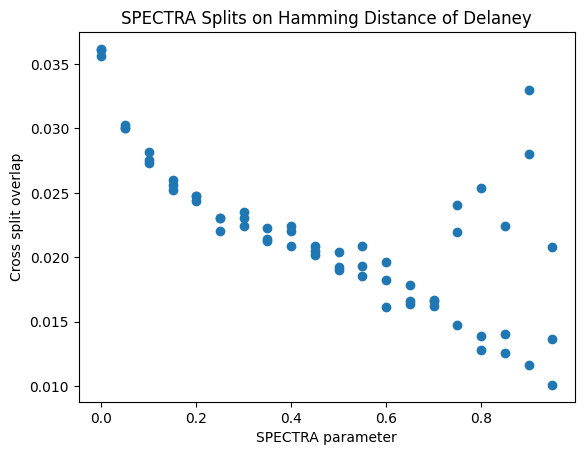

In [30]:
plt.scatter(stats_delaney_df['SPECTRA_parameter'], stats_delaney_df['cross_split_overlap'])
plt.xlabel('SPECTRA parameter')
plt.ylabel('Cross split overlap')
plt.title('SPECTRA Splits on Hamming Distance of Delaney')
plt.show()

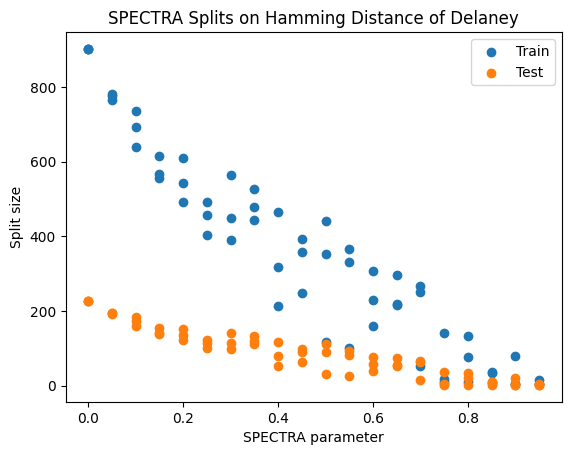

In [48]:
plt.scatter(stats_delaney_df['SPECTRA_parameter'], stats_delaney_df['train_size'])
plt.scatter(stats_delaney_df['SPECTRA_parameter'], stats_delaney_df['test_size'])
plt.xlabel('SPECTRA parameter')
plt.ylabel('Split size')
plt.legend(['Train','Test'])
plt.title('SPECTRA Splits on Hamming Distance of Delaney')
plt.show()

In [37]:
tasks, lipo_dataset, transformers = dc.molnet.load_lipo(splitter = None)
lipo_smiles = lipo_dataset[0].ids

In [38]:
mfp_lipo = []

for i in range(len(lipo_smiles)):
    mol = Chem.MolFromSmiles(lipo_smiles[i])
    fp = rdFingerprintGenerator.GetMorganGenerator(radius = 2, fpSize = 1024).GetFingerprint(mol)
    mfp_lipo.append(fp)

mfp_lipo = np.array(mfp_lipo)

In [39]:
lipo_dataset = molnet_dataset(mfp_lipo, 'lipo')
lipo_spectra = molnet_hamming_spectra(lipo_dataset, binary = False)
lipo_spectra.pre_calculate_spectra_properties('lipo', force_recalculate = False)

100%|██████████| 4200/4200 [00:26<00:00, 160.40it/s]


In [43]:
lipo_spectra.generate_spectra_splits(**spectra_parameters)

Folder SP_0.00_0 already exists. Skipping
Folder SP_0.00_1 already exists. Skipping
Folder SP_0.00_2 already exists. Skipping
Folder SP_0.05_0 already exists. Skipping
Folder SP_0.05_1 already exists. Skipping
Folder SP_0.05_2 already exists. Skipping
Folder SP_0.10_0 already exists. Skipping
Folder SP_0.10_1 already exists. Skipping
Folder SP_0.10_2 already exists. Skipping
Folder SP_0.15_0 already exists. Skipping
Folder SP_0.15_1 already exists. Skipping
Folder SP_0.15_2 already exists. Skipping
Folder SP_0.20_0 already exists. Skipping
Folder SP_0.20_1 already exists. Skipping
Folder SP_0.20_2 already exists. Skipping
Folder SP_0.25_0 already exists. Skipping
Folder SP_0.25_1 already exists. Skipping
Folder SP_0.25_2 already exists. Skipping
Folder SP_0.30_0 already exists. Skipping
Folder SP_0.30_1 already exists. Skipping
Folder SP_0.30_2 already exists. Skipping
Folder SP_0.35_0 already exists. Skipping
Folder SP_0.35_1 already exists. Skipping
Folder SP_0.35_2 already exists. S

[]

In [60]:
lipo_stats = lipo_spectra.return_all_split_stats()
lipo_stats_df = pd.DataFrame(lipo_stats).sort_values(by = 'SPECTRA_parameter', ascending = True)

print('SPECTRA Splits on Hamming Distance of Lipo')
print('----------------------')
for index, row in lipo_stats_df.iterrows():
    print(f'SPECTRA parameter: {row["SPECTRA_parameter"]}')
    print(f'Test size: {row["test_size"]} | Train size: {row["train_size"]}')
    print(f'Cross split overlap: {row["cross_split_overlap"]} \n')

lipo_spectra.return_split_samples(0.90,0)

SPECTRA Splits on Hamming Distance of Lipo
----------------------
SPECTRA parameter: 0.0
Test size: 840 | Train size: 3360
Cross split overlap: 0.07209703925515519 

SPECTRA parameter: 0.0
Test size: 840 | Train size: 3360
Cross split overlap: 0.07242871342873086 

SPECTRA parameter: 0.0
Test size: 840 | Train size: 3360
Cross split overlap: 0.0721766776779071 

SPECTRA parameter: 0.05
Test size: 629 | Train size: 2514
Cross split overlap: 0.06486069517557796 

SPECTRA parameter: 0.05
Test size: 609 | Train size: 2435
Cross split overlap: 0.06519903563568208 

SPECTRA parameter: 0.05
Test size: 618 | Train size: 2469
Cross split overlap: 0.06508118627084258 

SPECTRA parameter: 0.1
Test size: 516 | Train size: 2063
Cross split overlap: 0.061769840393695964 

SPECTRA parameter: 0.1
Test size: 529 | Train size: 2116
Cross split overlap: 0.06233206493263139 

SPECTRA parameter: 0.1
Test size: 515 | Train size: 2059
Cross split overlap: 0.062326566530081055 

SPECTRA parameter: 0.15
Test s

Exception: Split folder ./lipo_SPECTRA_splits/SP_0.9_0 does not exist

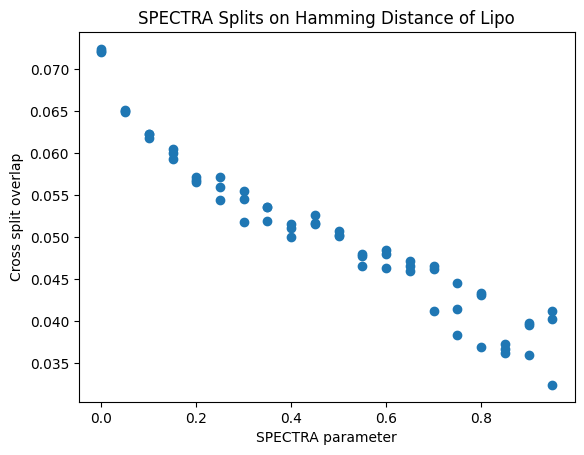

In [46]:
plt.scatter(lipo_stats['SPECTRA_parameter'], lipo_stats['cross_split_overlap'])
plt.xlabel('SPECTRA parameter')
plt.ylabel('Cross split overlap')
plt.title('SPECTRA Splits on Hamming Distance of Lipo')
plt.show()

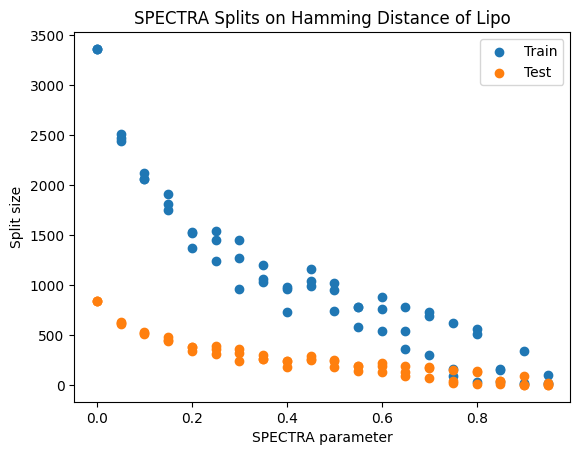

In [49]:
plt.scatter(lipo_stats['SPECTRA_parameter'], lipo_stats['train_size'])
plt.scatter(lipo_stats['SPECTRA_parameter'], lipo_stats['test_size'])
plt.xlabel('SPECTRA parameter')
plt.ylabel('Split size')
plt.title('SPECTRA Splits on Hamming Distance of Lipo')
plt.legend(['Train','Test'])
plt.show()

In [67]:
import pickle

with open("/Users/ivymac/Desktop/SAGE_Lab/spectra_hamming/bace/bace_SPECTRA_splits_hamming/SP_0.90_0/train.pkl", "rb") as f:
    split_data = pickle.load(f)
split_data
print(type(split_data))

<class 'list'>
